In [1]:
!pip install matplotlib
#mc cp s3/tordjx ummt --recursive
# watch -n 0.5 nvidia-smi

In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head = 8
num_encoder_layers = 8
num_decoder_layers = 8
dim_feedforward = 512
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 512

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"]).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"]).to(device)

#IF WE WANT TO LOAD PREVIOUSLY TRAINED MODEL
# model_en.load_state_dict(torch.load("model_en"))
# model_fr.load_state_dict(torch.load("model_fr"))

In [3]:
# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
train_features = torch.from_numpy(train_features)
val_features = torch.from_numpy(val_features)

In [ ]:
train_data_fr = [tokenized_fr, train_features]
train_data_en = [tokenized_en, train_features]
mixed_train(model_fr,model_en,train_data_fr,train_data_en,500,batch_size, True,[1/2,1])


/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Iteration : 0 batch numéro : 45 en 35 ms par itération, moyenne loss 6.523257197274102
Iteration : 0 batch numéro : 90 en 29 ms par itération, moyenne loss 3.885413312911987
Iteration : 0 batch numéro : 135 en 29 ms par itération, moyenne loss 3.15388838979933
Iteration : 0 batch numéro : 180 en 28 ms par itération, moyenne loss 2.770402389102512
Iteration : 0 batch numéro : 225 en 28 ms par itération, moyenne loss 2.501678217781915
Iteration : 0 batch numéro : 270 en 27 ms par itération, moyenne loss 2.2391608397165936
Iteration : 0 batch numéro : 315 en 29 ms par itération, moyenne loss 2.2641875637902156
Iteration : 0 batch numéro : 360 en 27 ms par itération, moyenne loss 2.055361662970649
Iteration : 0 batch numéro : 405 en 27 ms par itération, moyenne loss 1.929853524102105
Iteration : 0 batch numéro : 450 en 28 ms par itération, moyenne loss 1.9623960044648912
Iteration : 0 batch numéro : 452 en 0 ms par itération, moyenne loss 0.06773809591929118
Iteration : 1 batch numéro : 45

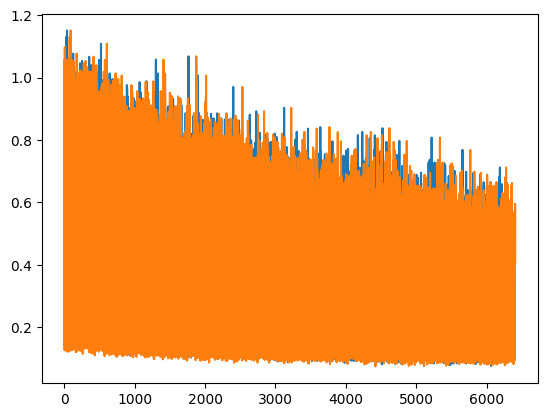

In [9]:
def moving_average(a, n=1) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
# plt.plot(model_en.loss_list)



In [7]:
torch.save(model_fr.state_dict(), "model_fr")
torch.save(model_en.state_dict(), "model_en")
import os
import s3fs
!pip install pandas
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("model_fr","tordjx/model_fr")
fs.upload("model_en","tordjx/model_fr")

In [11]:
#%%
train_data_fr = [tokenized_fr, train_features]
train_data_en = [tokenized_en, train_features]
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map,image_bool):
    model_en.eval()
    model_fr.eval()
    if image_bool : 
        data,features= data
    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data,features, True),dim = 2)[j]
    return tensor_to_sentence(output.view(-1),inv_map)



def donne_random():
    i = np.random.randint(len(tokenized_en)//batch_size)
    j = np.random.randint(batch_size)
    batched_data=batchify(train_data_en,batch_size,True)
    data,features = batched_data
    return data[i],features[i]

text,features = donne_random()
features = features.to(device,dtype=torch.float32)
data = [text,features]
for i in range(10):
    j = np.random.randint(batch_size)
    print("Phrase à traduire : \n" + tensor_to_sentence(text[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr,True))


#%%

/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Phrase à traduire : 
a woman with a white visor and blue top and white pants eating while standing in a crowd . 
 Phrase traduite : 
 un sur gun vregardent tsur dans , nts , và 
Phrase à traduire : 
a young boy is opening a present . 
 Phrase traduite : 
 un jeune enfants fusdest un 
Phrase à traduire : 
a group of people at a table with glasses of beer smiling . 
 Phrase traduite : 
 un trois ideux jeune un vgblanc idéderrière 
Phrase à traduire : 
several people stroll through a park with many trees . 
 Phrase traduite : 
 sont deux se vatandis par un er gt cou
Phrase à traduire : 
a woman is sitting down on the sidewalk is receiving a wristband given to her by another woman . 
 Phrase traduite : 
 un sur fe au pocftandis m. tregardent est un personnes parse er l&apos; tregardent . court anrorensur 
Phrase à traduire : 
a scene from a competitive marathon , including several participants , down a crowd-lined city street . 
 Phrase traduite : 
 un guitare chose un muà gens d&apos; td&